# The Timeseries Quantum Autoencoder - Data Exploration
*Compatible with PennyLane V0.41+*<br/>
*TS QAE in PennyLane with angle encoding of TS sliding windows*

**Author:** Jacob Cybulski<br>
**Date:** June 2025<br>
**Aims:** The goal of this notebook is to build sample data for a Time Series Quantum Autoencoder.

## Data
In mathematics and mathematical biology, the Mackey–Glass equations, named after Michael Mackey and Leon Glass, refer to a family of delay differential equations whose behaviour manages to mimic both healthy and pathological behaviour in certain biological contexts, controlled by the equation's parameters (<a href="https://en.wikipedia.org/wiki/Mackey%E2%80%93Glass_equations" target="_blank">Wikipedia</a>).

## Initial settings

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/site-packages',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/site-packages/setuptools/_vendor',
 '.']

In [3]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pylab
import math
from IPython.display import clear_output
%matplotlib inline

from utils.Files import create_folder_if_needed, write_json_file, write_ts_file
from utils.Tools import gen_calculated_noise, add_noise, multi_plot_flat_ts
from utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg

from matplotlib import set_loglevel
set_loglevel("error")

## Prepare windowed TS data
*Values need to be mapped into qubit state angles, in the range of [0+m..pi-m] where m is some small margin (e.g. 0.05)*

### Prepare time series

In [4]:
## Software version
major_version = 6
minor_version = 0

### Mmackey-Glass settings
beta=0.25    # Larger beta = stronger oscillations
gamma=0.1    # Keeps damping moderate
n=10         # Standard nonlinearity
tau=15       # Introduces chaos (try 17–30 for interesting behavior)
dt=1.0       # Coarse step (creates irregularities due to Euler integration)
T=300        # 300 steps (since dt=1.0, T=300 gives 300 values)

### Data encoding
margin = 0.2
scale_low = 0+margin
scale_high = 1 - margin

In [5]:
### Constants
LOG_NAME = 'aintern'
DATA_NAME = 'mackey_glass'
DATA_PATH = f'{LOG_NAME}/data'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Create a folder if needed
create_folder_if_needed(DATA_PATH)
create_folder_if_needed(FIGURES_PATH)

### Show constants
(LOG_NAME, DATA_NAME, DATA_PATH, FIGURES_PATH)

('aintern', 'mackey_glass', 'aintern/data', 'aintern/figures')

### Generate TS data

In [6]:
def scale_values(x, new_min=0, new_max=1):
    x_min, x_max = np.min(x), np.max(x)
    return new_min + (x - x_min) * (new_max - new_min) / (x_max - x_min)

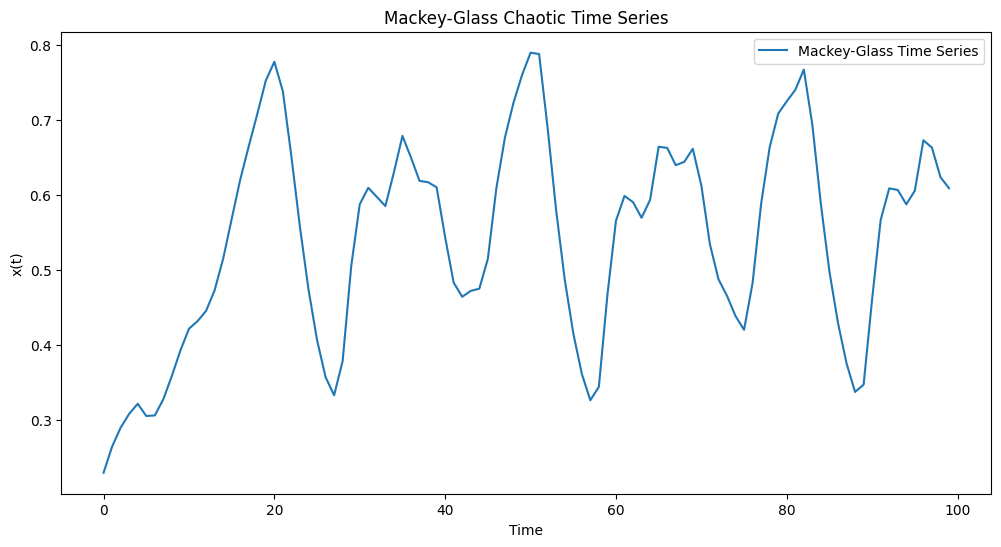

In [7]:
import numpy as np
import matplotlib.pyplot as plt

### Simulates the Mackey-Glass time series using the 4th-order Runge-Kutta method.
def mackey_glass(beta=0.2, gamma=0.1, n=10, tau=17, dt=0.1, T=1000):
    
    N = int(T / dt)                # Total number of time steps
    delay_steps = int(tau / dt)    # Delay in terms of steps
    x = np.zeros(N + delay_steps)  # Initialize time series with zeros
    x[0:delay_steps] = 1.2         # Initial condition

    for t in range(delay_steps, N + delay_steps - 1):
        x_tau = x[t - delay_steps]  # Delayed term
        dxdt = beta * x_tau / (1 + x_tau**n) - gamma * x[t]  # Mackey-Glass equation
        x[t + 1] = x[t] + dxdt * dt  # Euler integration

    return x[delay_steps:]  # Return only the valid part of the time series

# Generate and plot the Mackey-Glass time series
y_raw = mackey_glass(beta=beta, gamma=gamma, n=n, tau=tau, dt=dt, T=T)
y_raw = scale_values(y_raw, new_min=scale_low, new_max=scale_high)
y = y_raw[2::3]
X = np.array([i for i in range(len(y))])

plt.figure(figsize=(12, 6))
plt.plot(X, y, label='Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
# plt.ylim(0, math.pi+0.3)
plt.legend()
plt.show()

## Save generated data

In [8]:
### Data settings
split = 0.75
samples = len(y)

print(f'Samples: all={samples}')

Samples: all=100


In [9]:
### All created files have the following codes:
#   n: sample size
#   w: window size
#   ws: window step
#   z: level of noise injected
#   zr: replication number of noisy records
DATA_PREF = f'{DATA_NAME}_n{samples}'
DATA_PREF

'mackey_glass_n100'

In [10]:
### Define file names

x_org_fpath = f'{DATA_PATH}/{DATA_PREF}/x_org.arr'
y_org_fpath = f'{DATA_PATH}/{DATA_PREF}/y_org.arr'

info_file_path = f'{DATA_PATH}/{DATA_PREF}/info.json'

In [11]:
### Save data
#   Note: As noise needs to be generated during training
#         we will not save noisy data


data_to_be_saved = True

if data_to_be_saved:   
    write_ts_file(x_org_fpath, X)
    write_ts_file(y_org_fpath, y)
    print(f'\nSaved all time series data: "{DATA_PATH}" folder\n')
else:
    print(f'\nTime series data not saved\n') 


Saved all time series data: "aintern/data" folder



In [12]:
### Save info details

info_to_save = {\

    # Data ID details
    'data_name':DATA_NAME, 
    'major_version':major_version, 
    'minor_version':minor_version,

    # Data general configuration
    'samples':samples,

    # Data encoding configuration
    'scale_margin':margin,
    'scale_low':scale_low, 
    'scale_high':scale_high,

    # Mackey-Glass configuration
    'mackey_glass_beta':beta,
    'mackey_glass_gamma':gamma,
    'mackey_glass_n':n,
    'mackey_glass_tau':tau,
    'mackey_glass_dt':dt,
    'mackey_glass_T':T,
    }

### Saving the info file
if data_to_be_saved:
    write_json_file(info_file_path, info_to_save)
    print(f'\nSaved time series info in file "{info_file_path}":\n')
else:
    print(f'\nTime series info  not saved:\n') 
    
### Show what has been saved
for k in info_to_save.keys():
    print(f'\tinfo[{k}] = {info_to_save[k]}')
print()


Saved time series info in file "aintern/data/mackey_glass_n100/info.json":

	info[data_name] = mackey_glass
	info[major_version] = 6
	info[minor_version] = 0
	info[samples] = 100
	info[scale_margin] = 0.2
	info[scale_low] = 0.2
	info[scale_high] = 0.8
	info[mackey_glass_beta] = 0.25
	info[mackey_glass_gamma] = 0.1
	info[mackey_glass_n] = 10
	info[mackey_glass_tau] = 15
	info[mackey_glass_dt] = 1.0
	info[mackey_glass_T] = 300



# Software (Linux)

In [13]:
import os
os.system('pip list | grep -e PennyLane -e torch');

PennyLane                     0.41.1
PennyLane_Lightning           0.41.1
torch                         2.7.0
torchaudio                    2.7.0
torchsummary                  1.5.1
torchvision                   0.22.0
